# Introduction to Authentication using Behavioral Biometrics

This jupyter notebook is part of the [Introduction to Authentication using Behavioral Biometrics](https://behavioral-biometrics.org/). Please check the website for further information, in addition to the other course materials.

## Case-Study on Virtual Reality Behavioral Biometrics

This notebook handles an excerpt of the dataset of the publication "Understanding User Identification in Virtual Reality Through Behavioral Biometrics and the Effect of Body Normalization". The original paper can be retrieved [here](https://www.hci.wiwi.uni-due.de/fileadmin/fileupload/I-HCI/Paper/Understanding_User_Identification_in_Virtual_Reality_Through_Behavioral_Biometrics_and_the_Effect_of_Body_Normalization.pdf) and the dataset can be obtained from the [web](https://www.hci.wiwi.uni-due.de/en/publikationen/understanding-user-identification-in-virtual-reality-through-behavioral-biometrics-and-the-effect-of-body-normalization/).

We hold this notebook deliberately simple. This means, that we focus mostly on standard constructs of the Python programming language. Particularly, we try to avoid highly-dense numpy and pandas code, which is highly performant, but may limit understanding due to its density. Therefore, some of the loops might have a technical drawback, but for understanding the workflow, we believe that they are beneficial.

## Overview

This notebook implements three parts:
1. Enrolment, data vizualization and data inspection,
2. A feature-preprocessing based on aggregate functions, and 
3. A closed-set identification system.

Additionally, this notebook implements functions to understand and explore the data through descriptive statistics and visualizations.

In [1]:
use_backup_dataset = False

In [2]:
import sys
print('Your python version is:', sys.version)

Your python version is: 3.10.7 (tags/v3.10.7:6cc6b13, Sep  5 2022, 14:08:36) [MSC v.1933 64 bit (AMD64)]


### Enrolment

In the enrolment phase, we first load the dataset from the internet and store it in memory. We access a pre-defined json that is available for this course on the web and load it into a pandas dataframe.

In [3]:
import pandas as pd
import numpy as np


if use_backup_dataset:
    dataset_df = pd.read_json("https://archery23.hcigroup.de/select-bak.php")
else:
    dataset_df = pd.read_json("https://archery23.hcigroup.de/select.php")
print(f"Dataset of shape {dataset_df.shape} (num_rows, num_columns) loaded.")

Dataset of shape (54301, 29) (num_rows, num_columns) loaded.


The dataset has the following columns:

In [4]:
dataset_df.columns

Index(['participant_ID', 'session_ID', 'timestamp', 'CenterPos_x',
       'CenterPos_y', 'CenterPos_z', 'CenterEuler_x', 'CenterEuler_y',
       'CenterEuler_z', 'LeftPos_x', 'LeftPos_y', 'LeftPos_z', 'LeftEuler_x',
       'LeftEuler_y', 'LeftEuler_z', 'RightPos_x', 'RightPos_y', 'RightPos_z',
       'RightEuler_x', 'RightEuler_y', 'RightEuler_z', 'ArrowPos_x',
       'ArrowPos_y', 'ArrowPos_z', 'ArrowEuler_x', 'ArrowEuler_y',
       'ArrowEuler_z', 'ArrowsShot', 'phase'],
      dtype='object')

We see many columns:

*   All the columns that start with `Center` are related to the center-piece of the head-mounted display (HMD), i.e., the head-piece.
*   All the columns that start with either `Left` or `Right` are for the left or right controller, respectively.
*   `Pos` denotes the position and `Euler` the rotation. Position is in Euclidean coordinates for x, y, z, and `Euler` are angles between zero and 360.
*   The Y-axis for position is "up", i.e., pointed towards the sky.
*   `participant_ID` is the participant's identifying number, `session_ID` the ID of the session and `ArrowsShot` denotes, how many arrows this participant has shot. The three variables, in conjunction, can describe each individually shot arrow.
*   `phase` is the phase of the movement, where 0 is the very beginning, 1 starts once the arrow was attached to the bow, 2 is when the bow is drawn, and 3 is when the arrow is released. The phase therefore divides a movement into four different segments.
*   `timestamp` is an integer timestamp (unixtime) in milliseconds.

We take a brief look at the data. We can print variables by adding them in the last line of a cell.

In [5]:
dataset_df

participant_ID  session_ID               timestamp  CenterPos_x  \
0          Quest2_15           1 2023-04-25 13:21:45.101     20.41248   
1          Quest2_15           1 2023-04-25 13:21:45.111     20.41207   
2          Quest2_15           1 2023-04-25 13:21:45.125     20.41163   
3          Quest2_15           1 2023-04-25 13:21:45.139     20.41124   
4          Quest2_15           1 2023-04-25 13:21:45.153     20.41096   
...              ...         ...                     ...          ...   
54296       Quest2_4           2 2023-04-25 14:41:29.272     20.36887   
54297       Quest2_4           2 2023-04-25 14:41:29.285     20.36869   
54298       Quest2_4           2 2023-04-25 14:41:29.299     20.36850   
54299       Quest2_4           2 2023-04-25 14:41:29.313     20.36833   
54300       Quest2_4           2 2023-04-25 14:41:29.327     20.36818   

       CenterPos_y  CenterPos_z  CenterEuler_x  CenterEuler_y  CenterEuler_z  \
0         1.775632     28.34067      14.841250       0.475732       359.4627   
1         1.775644     28.34056      14.882500       0.409210       359.4058   
2         1.775694     28.34053      14.912770       0.355781       359.4101   
3         1.775721     28.34055      14.887040       0.206938       359.5174   
4         1.775782     28.34062      14.797690       0.013066       359.6086   
...            ...          ...            ...            ...            ...   
54296     1.544397     28.38248       7.152605      13.104310       354.7867   
54297     1.544372     28.38245       7.163318      13.080180       354.7696   
54298     1.544375     28.38244       7.206391      13.054560       354.7794   
54299     1.544357     28.38243       7.165317      13.049740       354.7814   
54300     1.544383     28.38243       7.178877      13.073940       354.7719   

       LeftPos_x  ...  RightEuler_y  RightEuler_z  ArrowPos_x  ArrowPos_y  \
0       20.49654  ...     345.22020      289.3746    19.45500    1.205000   
1       20.49628  ...     345.35220      289.6210    19.45500    1.205000   
2       20.49603  ...     345.31590      289.9447    19.45500    1.205000   
3       20.49590  ...     345.34930      290.5965    19.45500    1.205000   
4       20.49595  ...     345.43830      291.3468    19.45500    1.205000   
...          ...  ...           ...           ...         ...         ...   
54296   20.38344  ...      14.69787      275.0416    20.35760    1.478248   
54297   20.38349  ...      14.67882      275.0047    20.35209    1.478193   
54298   20.38354  ...      14.69777      274.9720    20.34659    1.475931   
54299   20.38362  ...      14.76503      274.9480    20.34292    1.473197   
54300   20.38367  ...      14.86124      274.8486    20.33741    1.467256   

       ArrowPos_z  ArrowEuler_x  ArrowEuler_y  ArrowEuler_z  ArrowsShot  phase  
0        28.30000      0.000000        0.0000      0.000000           1      0  
1        28.30000      0.000000        0.0000      0.000000           1      0  
2        28.30000      0.000000        0.0000      0.000000           1      0  
3        28.30000      0.000000        0.0000      0.000000           1      0  
4        28.30000      0.000000        0.0000      0.000000           1      0  
...           ...           ...           ...           ...         ...    ...  
54296    30.44963    359.578900      358.9229      5.475366          12      3  
54297    30.74243      0.010689      358.9229      5.475415          12      3  
54298    31.03523      0.442517      358.9229      5.475468          12      3  
54299    31.23043      0.730378      358.9229      5.475502          12      3  
54300    31.52324      1.162096      358.9229      5.475552          12      3  

[54301 rows x 29 columns]

In [6]:
print(f'The following headsets are in the database: {dataset_df.participant_ID.unique()}')

The following headsets are in the database: ['Quest2_15' 'Quest2_13' 'Quest2_3' 'Quest2_1' 'Quest2_4']


#### Visualization and Inspection

In the next section, we are going to explore the data. To do so, we visualize behavioral samples, check all sample's lengths and search for anomalies within the data.

The data consists of behavioral data in the form of spatiotemporal movement data, and a phase. The phase provides an information on the user's current interaction. For Archery, the phases are defined as following:

0. The user is standing in the world and looking around.
1. The user has grabbed an arrow from the quiver.
2. The user attached this arrow to the bow and is aiming.
3. The arrow is released and en route to the target.

##### Task 1: Checking variables

First, take a look at the values of the `dataset_df`-object. Do so, by printing it in the next cell. (Hint: in the cells above, you can already find some code to print variables.)

In [7]:
# Task 1

# ... your solution here ...
dataset_df

participant_ID  session_ID               timestamp  CenterPos_x  \
0          Quest2_15           1 2023-04-25 13:21:45.101     20.41248   
1          Quest2_15           1 2023-04-25 13:21:45.111     20.41207   
2          Quest2_15           1 2023-04-25 13:21:45.125     20.41163   
3          Quest2_15           1 2023-04-25 13:21:45.139     20.41124   
4          Quest2_15           1 2023-04-25 13:21:45.153     20.41096   
...              ...         ...                     ...          ...   
54296       Quest2_4           2 2023-04-25 14:41:29.272     20.36887   
54297       Quest2_4           2 2023-04-25 14:41:29.285     20.36869   
54298       Quest2_4           2 2023-04-25 14:41:29.299     20.36850   
54299       Quest2_4           2 2023-04-25 14:41:29.313     20.36833   
54300       Quest2_4           2 2023-04-25 14:41:29.327     20.36818   

       CenterPos_y  CenterPos_z  CenterEuler_x  CenterEuler_y  CenterEuler_z  \
0         1.775632     28.34067      14.841250       0.475732       359.4627   
1         1.775644     28.34056      14.882500       0.409210       359.4058   
2         1.775694     28.34053      14.912770       0.355781       359.4101   
3         1.775721     28.34055      14.887040       0.206938       359.5174   
4         1.775782     28.34062      14.797690       0.013066       359.6086   
...            ...          ...            ...            ...            ...   
54296     1.544397     28.38248       7.152605      13.104310       354.7867   
54297     1.544372     28.38245       7.163318      13.080180       354.7696   
54298     1.544375     28.38244       7.206391      13.054560       354.7794   
54299     1.544357     28.38243       7.165317      13.049740       354.7814   
54300     1.544383     28.38243       7.178877      13.073940       354.7719   

       LeftPos_x  ...  RightEuler_y  RightEuler_z  ArrowPos_x  ArrowPos_y  \
0       20.49654  ...     345.22020      289.3746    19.45500    1.205000   
1       20.49628  ...     345.35220      289.6210    19.45500    1.205000   
2       20.49603  ...     345.31590      289.9447    19.45500    1.205000   
3       20.49590  ...     345.34930      290.5965    19.45500    1.205000   
4       20.49595  ...     345.43830      291.3468    19.45500    1.205000   
...          ...  ...           ...           ...         ...         ...   
54296   20.38344  ...      14.69787      275.0416    20.35760    1.478248   
54297   20.38349  ...      14.67882      275.0047    20.35209    1.478193   
54298   20.38354  ...      14.69777      274.9720    20.34659    1.475931   
54299   20.38362  ...      14.76503      274.9480    20.34292    1.473197   
54300   20.38367  ...      14.86124      274.8486    20.33741    1.467256   

       ArrowPos_z  ArrowEuler_x  ArrowEuler_y  ArrowEuler_z  ArrowsShot  phase  
0        28.30000      0.000000        0.0000      0.000000           1      0  
1        28.30000      0.000000        0.0000      0.000000           1      0  
2        28.30000      0.000000        0.0000      0.000000           1      0  
3        28.30000      0.000000        0.0000      0.000000           1      0  
4        28.30000      0.000000        0.0000      0.000000           1      0  
...           ...           ...           ...           ...         ...    ...  
54296    30.44963    359.578900      358.9229      5.475366          12      3  
54297    30.74243      0.010689      358.9229      5.475415          12      3  
54298    31.03523      0.442517      358.9229      5.475468          12      3  
54299    31.23043      0.730378      358.9229      5.475502          12      3  
54300    31.52324      1.162096      358.9229      5.475552          12      3  

[54301 rows x 29 columns]

##### Task 2: Boxplotting Height

Next, we want to understand the deviations in height. Each participant's height is denoted by the y-axis of the center piece of the HMD. Using plotly, we can easily gain insights into the different reported heights. The height of each participant can change between sessions, if they put on the HMD in an odd way, during one session, if they voluntarily crouch, or, due to general sensor noise.

Please create a boxplot in plotly using the `px.box()` function. You need four parameters. The first parameter is the dataframe. Then, the named parameter `x=` receives a column-name for the description of the x-axis. As the named `y=` parameter, we take the column-name that denotes the participants' height. Last, we can use `color=` to create color-grouped boxplots (e.g., session-wise).

Hint: The function call can look like this: `px.box(<dataframe>, x='<columnname>', y='<columnname>', color='<columnname>')`.

In [8]:
# Task 2

import plotly.express as px

# ... your solution here ...
px.box(dataset_df, x='participant_ID', y='CenterPos_y', color='session_ID')

##### Task 3: Counting sample lengths

Next, we want to count, how many rows exist in the data for each arrow that was shot.

Each row in the dataframe corresponds to exactly one frame that was generated by the VR device. The device that was used to elicit the data sampled at 72 hz, i.e., 72 frames per second. However, some people likely took longer to shoot an arrow than others due to natural variance in behavior. Now, we want to count the frames per shot arrow so that we have a rough understanding how long each arrow-shooting interaction took.

Hint: You need to take the dataframe and group it by the three describing identifier-variables, that are related to the participant, session, and the number of shot arrows. You can look up the column names above.

To count, you can *apply* a counting function such as *len*, after you group the dataframe by the three identifier variables. Or in other words: create a list of strings that contains the three identifier-columns, use it in combination with the `.groupby()`-function and `.apply` the `len`-function then.

In [9]:
# Task 3

# ... your solution here ...
dataset_df.groupby(['participant_ID', 'session_ID', 'ArrowsShot']).apply(len)

participant_ID  session_ID  ArrowsShot
Quest2_1        1           2             842
                            3             396
                            4             516
                            5             416
                            6             496
                                         ... 
Quest2_4        2           8             460
                            9             394
                            10            547
                            11            461
                            12             11
Length: 119, dtype: int64

##### Task 4: Descriptive statistics

After obtaining your result from Task 3, generate some descriptive statistics.
Identify the fastest-shot arrows according to the number of frames it took to shoot the arrow. Divide the value manually by 72. How many seconds did it take, to shoot the quickest-drawn arrow?

Hint: apply the `.describe()`-function to your result from Task 3.

In [10]:
# Task 4

# ... your solution here ...
dataset_df.groupby(['participant_ID', 'session_ID', 'ArrowsShot']).apply(len).describe()

count     119.000000
mean      456.310924
std       298.585188
min        11.000000
25%       324.500000
50%       385.000000
75%       553.000000
max      1675.000000
dtype: float64

##### Task 5: Scatterplotting movement

The following cell has code to 3D-scatterplot spatiotemporal movements, given a `participant_ID`, a `session_ID`, and an `arrow_ID`. Create a couple of boxplots and try to find your own, odd movements, from the second archery sessions. Write down the identifiers for these movements.

In [11]:
def visualize_sample(df: pd.DataFrame, 
                     participantID, 
                     sessionID: int, 
                     arrowID: int) -> None:
    """This function creates a spatial, 3D scatterplot, given a dataframe of
    coordinates (df) and concrete values for participantID (int or str), 
    sessionID (integer), and arrowID (integer)."""
    import plotly.express as px
    import plotly.graph_objects as go
    
    # info: in plotly, Z is the upwards axis. In Unity, Y is the upwards axis. 
    # hence, they are interchanged here. 
    fig1 = px.scatter_3d(dataset_df.loc[(dataset_df['participant_ID'] == participantID) & 
                                        (dataset_df['session_ID'] == sessionID) & 
                                        (dataset_df['ArrowsShot'] == arrowID)], 
                                        x='CenterPos_x', 
                                        y='CenterPos_z', 
                                        z='CenterPos_y',
                                        color='phase', 
                                        symbol_sequence='x')
    fig2 = px.scatter_3d(dataset_df.loc[(dataset_df['participant_ID'] == participantID) & 
                                        (dataset_df['session_ID'] == sessionID) & 
                                        (dataset_df['ArrowsShot'] == arrowID)], 
                                        x='LeftPos_x', 
                                        y='LeftPos_z', 
                                        z='LeftPos_y',
                                        color='phase', 
                                        symbol_sequence=['circle-open'])
    fig3 = px.scatter_3d(dataset_df.loc[(dataset_df['participant_ID'] == participantID) & 
                                        (dataset_df['session_ID'] == sessionID) & 
                                        (dataset_df['ArrowsShot'] == arrowID)], 
                                        x='RightPos_x', 
                                        y='RightPos_z', 
                                        z='RightPos_y',
                                        color='phase', 
                                        symbol_sequence=['circle'])
    fig4 = go.Figure(data=fig1.data + fig2.data + fig3.data)
    fig4.show()


visualize_sample(dataset_df, participantID="Quest2_4", sessionID=1, arrowID=1)

### Pre-Processing

At last, we employ a simple feature processing. For each column in each dataframe, the min, max, mean, and SD shall be calculated. This will result in four values per column. Of course, a more fancy approach could be chosen, too, or deep learning could be employed, that promises to craft the features automatically during the training process.

In [12]:
def feature_crafting(df: pd.DataFrame) -> list:
    """Crafts features by calculating min, max, mean, and sd for each column. 
    Returns a list with four entries per column."""
    dictionaries_list = []

    unique_participant_ids = df['participant_ID'].unique()
    unique_session_ids = df['session_ID'].unique()
    unique_arrowsshot_ids = df['ArrowsShot'].unique()

    # we iterate over the identifier columns and identify each unique sample
    for p_id in unique_participant_ids:
      for s_id in unique_session_ids:
        for a_id in unique_arrowsshot_ids:
          # we select the necessar data by the respective identifier variables
          # to describe exactly one sample
          select_df = df.loc[(dataset_df['participant_ID'] == p_id) & 
                             (dataset_df['session_ID'] == s_id) & 
                             (dataset_df['ArrowsShot'] == a_id)]

          # we identify each sample by the identifier columns
          # then we calculate min, max, mean, sd for that sample
          # but only for the columns that are related to positional 
          # or rotational coordinates.
          # we add all of this information to a dictionary for easier handling.

          feature_vector = []
          for column in select_df.columns:
            if 'pos' in column.lower() or 'euler' in column.lower():
              feature_vector.append(select_df[column].min())
              feature_vector.append(select_df[column].max())
              feature_vector.append(select_df[column].mean())
              feature_vector.append(select_df[column].std())
          dictionaries_list.append({'participant': p_id,
                                    'session': s_id,
                                    'arrowsshot': a_id,
                                    'features': feature_vector})
    return dictionaries_list

data_dict_list = feature_crafting(dataset_df)

### Closed-Set Identification

In the following, we create a random forrest classifier to identify the users in a closed-set style.

The first cell contains a code that uses the first 6 shot arrows for training and the last 6 shot arrows for testing, while only using session 1 to draw the data from.

The second cell performs training with all data from session 1 and identifies people with all data from session 2.

Comparing the accuracy values, what do you find?

Accuracy is 0.9


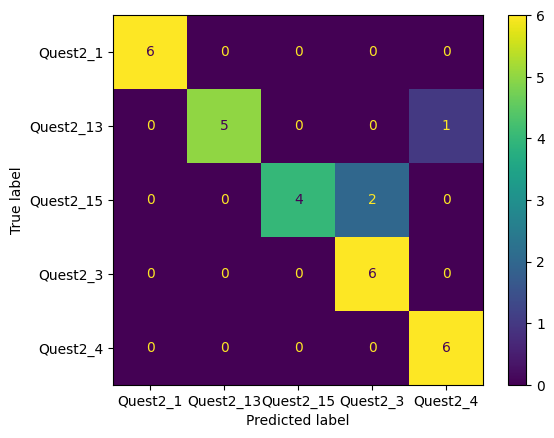

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

train_data = [d['features'] for d in data_dict_list if d['session'] == 1 and d['arrowsshot'] <= 6]
train_labels = [d['participant'] for d in data_dict_list if d['session'] == 1 and d['arrowsshot'] <= 6]

clf = RandomForestClassifier()
clf.fit(np.nan_to_num(train_data), train_labels)

test_data = [d['features'] for d in data_dict_list if d['session'] == 1 and d['arrowsshot'] >= 7]
test_labels = [d['participant'] for d in data_dict_list if d['session'] == 1 and d['arrowsshot'] >= 7]
pred = clf.predict(np.nan_to_num(test_data))

cm = confusion_matrix(test_labels, pred)
ConfusionMatrixDisplay(cm, display_labels=clf.classes_).plot()
acc = accuracy_score(test_labels, pred)
print('Accuracy is', acc)

Accuracy is 0.6833333333333333


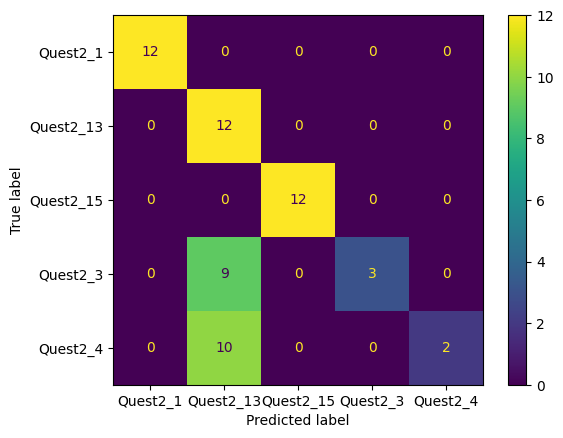

In [14]:
train_data = [d['features'] for d in data_dict_list if d['session'] == 1]
train_labels = [d['participant'] for d in data_dict_list if d['session'] == 1]

clf = RandomForestClassifier()
clf.fit(np.nan_to_num(train_data), train_labels)

test_data = [d['features'] for d in data_dict_list if d['session'] == 2]
test_labels = [d['participant'] for d in data_dict_list if d['session'] == 2]
pred = clf.predict(np.nan_to_num(test_data))

cm = confusion_matrix(test_labels, pred)
ConfusionMatrixDisplay(cm, display_labels=clf.classes_).plot()
acc = accuracy_score(test_labels, pred)
print('Accuracy is', acc)

In [ ]:
print("End of notebook execution.")